## NOTES:
<ul>
<li>Sections labeled <strong>CORE</strong> must be run in order to begin Aquifer Analysis</li>
<li>Cells labeled <strong>Control</strong> contain inputs for the immeadiately preceeding section(s)</li>
<li>Sections labeled <strong>EXTRA</strong> contain additional plotting or analysis tools but are not necessary for Aquifer Analysis</li>
</ul>

## CORE: Imports

In [16]:
#Python3.10
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pymannkendall as mk
import contextily as cx
import requests

from sklearn.preprocessing import MinMaxScaler
from dateutil import relativedelta
from datetime import datetime
from shapely.geometry import Point
from io import StringIO
from mpl_toolkits.axes_grid1 import make_axes_locatable

# USGS Data retreival tool
from dataretrieval import nwis, utils, codes

# TODO: Look into the warning that this is disabling. It doesn't appear to be significant for the purposes of this code but it needs to be understood
pd.options.mode.chained_assignment = None
#pd.options.mode.chained_assignment = 'warn'

## CORE: Classes
This class is just used for testing purposes and is not actually needed to run the full Aquifer Analysis, but is needed to run single site analysis independently

In [3]:
class StreamGauge:
    def __init__(self, id, name, mean_start_date, mean_end_date, post_start_date, post_end_date):
        self.id = id
        self.name = name
        # Start date for all-time mean daily flow data
        self.mean_start_date = mean_start_date
        self.mean_end_date = mean_end_date
        # Start date for post-impairment mean daily flow data
        self.post_start_date = post_start_date
        self.post_end_date = post_end_date 
        
    def get_id(self):
        """Return stream gauge USGS ID"""
        return self.id  
    
    def get_name(self):
        return self.name     
        
    def get_mean_date_range(self):
        """Return a time delta object between the start and end of the full record of streamflow data"""
        start_date = datetime.strptime(self.mean_start_date, "%Y-%m-%d")
        end_date = datetime.strptime(self.mean_end_date, "%Y-%m-%d")
        return relativedelta.relativedelta(end_date, start_date)
    
    def get_post_date_range(self):
        """Return a time delta object between the start and end of the post-impairment record of streamflow data"""
        start_date = datetime.strptime(self.post_start_date, "%Y-%m-%d")
        end_date = datetime.strptime(self.post_end_date, "%Y-%m-%d")
        return relativedelta.relativedelta(end_date, start_date)

## CORE: Inputs
Code control inputs and constants, some being defined by the proposal abstract

In [9]:
# 11447650 -- Sacramento River Basin
# 11303500 -- San Joaquin-Tulare Basin
# SRB -- '1970-01-01' '2014-01-01'
# SJTB -- '1989-01-01' '2014-01-01'
# Water year -- Oct 1-Sept 30
        
SRB_Guage = StreamGauge('11447650', 'SACRAMENTO R A FREEPORT CA', '1948-10-01', '2014-09-30', '1970-10-01', '2014-09-30')
SJTB_Guage = StreamGauge('11303500', 'SAN JOAQUIN R NR VERNALIS CA', '1923-10-01', '2014-09-30', '1989-10-01', '2014-09-30')

# Change this to modify analysis values (for testing)
curr_guage = SRB_Guage

# Sorty by Watershed Boundary
SORT_BY_WB = True

QUANTILE = 0.90
DEFAULT_START = '1900-10-01'
DEFAULT_END = '2020-09-30'
STATE_CODE = 'CA'
HYDRO_YEAR = 'AS-OCT'
SERVICE = 'dv'
MIN_DATA_PERIOD = 50
MAX_MISSING_THRESHOLD = 0.90
MK_TREND_ALPHA = 0.05

# 00060 -- Discharge
# 00010 -- Temperature
PARAM_CODE = '00060'

# Site ID URI
SITES_URI = f'https://waterdata.usgs.gov/{STATE_CODE}/nwis/current?index_pmcode_STATION_NM=1&index_pmcode_DATETIME=2&index_pmcode_{PARAM_CODE}=3&group_key=NONE&format=sitefile_output&sitefile_output_format=rdb&column_name=site_no&column_name=station_nm&column_name=dec_lat_va&column_name=dec_long_va&column_name=sv_begin_date&column_name=sv_end_date&sort_key_2=site_no&html_table_group_key=NONE&rdb_compression=file&list_of_search_criteria=realtime_parameter_selection'

## CORE: Functions
These are the primary streamflow analysis functions for calculating the required metrics, as well as general dataframe processing

In [10]:
# CONSTANTS
SEC_PER_DAY = 86400
CUBIC_FT_KM_FACTOR = 0.0000000000283168466

# FUNCTIONS
def validate(df: pd.DataFrame, start: datetime, end: datetime, report: bool):
    """Validates that no more than MAX_MISSING_THRESHOLD (10%) of data is missing from a given gauge"""
    t_delta = pd.to_datetime(end) - pd.to_datetime(start)
    days = t_delta.days           
    return ((len(df) / days) > MAX_MISSING_THRESHOLD)

def calc_threshold(df: pd.DataFrame, value: float):
    """Returns a threshold above which flow is considered HMF given flow values and a threshold 0 < t < 1""" 
    df = pd.DataFrame(df['00060_Mean'])
    return df.quantile(q=value, axis=0).iloc[0]

def filter_hmf(df: pd.DataFrame, threshold: float):
    """Returns a dataframe with only flow values above a given threshold present, and a second with non-HMF years zero deflated"""
    zero_defalted_hmf = df.copy()
    hmf_series = df[df['00060_Mean'] > threshold]    
    zero_defalted_hmf['00060_Mean'] = zero_defalted_hmf['00060_Mean'].apply(lambda x: x if x >= threshold else 0) 
    return hmf_series, zero_defalted_hmf

def convert_hmf(df: pd.DataFrame, threshold: float):
    """Converts flow values from ft^3/s to ft^3/day and returns only excess flow above a given threshold"""
    return (df['00060_Mean'] - threshold) * SEC_PER_DAY

def num_hmf_years(df: pd.DataFrame, offset: int):
    """Returns the integer number of HMF years, using an offset to indicate the start of the Hydrologic Year (i.e. 10 = October)"""
    df.loc[:, 'datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)    
    df.loc[:, 'offsetdate'] = (df.index - pd.offsets.YearBegin(month=offset))    
    return df['offsetdate'].dt.year.nunique()

def three_six_range(df: pd.DataFrame, three_start: int, three_end: int, six_start: int, six_end: int):
    """Returns two dataframes, one with a six month period, and one with a three month period, based on given start and end months for both"""
    df = df.reset_index()
    df.loc[:, 'datetime'] = pd.to_datetime(df['datetime'])    
    six_month_mask = (df['datetime'].dt.month >= six_start) | (df['datetime'].dt.month <= six_end)
    three_month_mask = (df['datetime'].dt.month >= three_start) | (df['datetime'].dt.month <= three_end)
    return df[six_month_mask], df[three_month_mask]

def calc_duration(df: pd.DataFrame):
    """Returns the total number of HMF days over the dataframes time period"""
    df.loc[:, 'datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)  
    df_results = df.resample(HYDRO_YEAR).agg({'00060_Mean': ['count']})
    df_results.columns = ['Count']
    return df_results['Count'].sum()

def calc_intra_annual(df: pd.Series, hmf_years: int):
    """Calculates the number of HMF events per hydrological year (consecutive days count as one event)""" 
    df = df.reset_index()   
    # Offsetting dates to make calculations easier (currently HARDCODED)
    date_series = pd.to_datetime(df['datetime'])        
    date_series = date_series + pd.DateOffset(months=-9)
    
    df = pd.DataFrame(columns=['Year'])
    
    for i in range(len(date_series)):
        if i == 0:   
            df = pd.concat([df, pd.DataFrame({'Year': date_series.iloc[i].year}, index=[i])], ignore_index=True, axis=0)                          
        else:
            if (date_series.iloc[i] - date_series.iloc[i - 1]).days > 1:
                df = pd.concat([df, pd.DataFrame({'Year': date_series.iloc[i].year}, index=[i])], ignore_index=True, axis=0)
    
    df = df.groupby('Year').size().reset_index(name='hmf_events')
    return df['hmf_events'].sum() / hmf_years

def calc_oneday_peaks(df: pd.DataFrame, hydro_year: str):
    """Calculates the number of one-day peaks per hydrological year"""    
    return
    
def convert_cubic_ft_hm(value: float):
    """Convert ft^3 to km^3"""
    return value * CUBIC_FT_KM_FACTOR

def mann_kendall(data: pd.Series, alpha: float):
    """Perform a Mann-Kendall Trend test"""
    return mk.original_test(data, alpha=alpha)

def create_state_uri(state: str, param: str):
    return f'https://waterdata.usgs.gov/{state}/nwis/current?index_pmcode_STATION_NM=1&index_pmcode_DATETIME=2&index_pmcode_{PARAM_CODE}=3&group_key=NONE&format=sitefile_output&sitefile_output_format=rdb&column_name=site_no&column_name=station_nm&column_name=dec_lat_va&column_name=dec_long_va&column_name=sv_begin_date&column_name=sv_end_date&sort_key_2=site_no&html_table_group_key=NONE&rdb_compression=file&list_of_search_criteria=realtime_parameter_selection'
    
    
def filter_by_valid(df: pd.DataFrame):
    """Filters a dataframe by it's 'valid' column and returns two dataframes, the first being valid and second invalid gauges"""
    df_valid = df[df['valid'] == True]
    df_invalid = df[df['valid'] == False]    
    return df_valid, df_invalid

def gages_2_filtering(df: pd.DataFrame):
    """Adds a column to the site dataframe indicating presence in the HCDN-2009 Gages-II Network"""
    path = 'GagesII/gagesII_sept30_2011_conterm.xlsx'
    sheet = 'BasinID'
    df_g2 = pd.read_excel(path, sheet_name=sheet)
    df_g2 = df_g2[df_g2['HCDN-2009'] == 'yes']        
    df['HCDN_2009'] = df['site_no'].isin(df_g2['STAID'])  
    return df

    

## CORE: Single Site Data<br>
This function produces the streamflow analysis (using the functions above) for a single site given a list of thresholds and time windows to analyze

In [11]:
# df2 holds all-time data, df is analyzed range
df = nwis.get_record(sites=curr_guage.id, service=SERVICE, parameterCD=PARAM_CODE, start=curr_guage.post_start_date, end=curr_guage.post_end_date)
df2 = nwis.get_record(sites=curr_guage.id, service=SERVICE, parameterCD=PARAM_CODE, start=curr_guage.mean_start_date, end=curr_guage.mean_end_date)

# If looking at a post impairment period, but calculating threshold based on the full record of data, pass a second dataframe with a different 
# start/end date as df2, otherwise pass df twice
def single_site_data(df: pd.DataFrame, df2: pd.DataFrame, start: datetime, end: datetime):
    df = df.reset_index()
    df2 = df2.reset_index()
    #df.to_csv('srb_full.csv')
    #print(df.loc[0, 'datetime'].date())
    
    # Validate that site is not missing > 10% of data and has >50 years
    valid = validate(df, start, end, True)
    
    # 90th percentile calculation
    threshold = calc_threshold(df2, QUANTILE)    

    # Create a dataframe with only days over HMF threshold as well as zero-deflated dataframe for MK trend test
    hmf_series, zero_deflated_hmf = filter_hmf(df, threshold)
    #print(zero_deflated_hmf)
    
    # Aggregate data before performing MK, set on-HMF years to 0
    agg_series = pd.DataFrame(zero_deflated_hmf)
    agg_series.set_index('datetime', inplace=True)
    agg_series = agg_series.resample(HYDRO_YEAR).agg({'00060_Mean': ['sum', 'count']})
    agg_series.columns = ['Sum', 'Count']
    #agg_series = agg_series[agg_series['Sum'] > 0]
    #agg_series.to_csv('agg_series.csv')
    
    mk_result = mann_kendall(convert_cubic_ft_hm(agg_series['Sum']), MK_TREND_ALPHA)
    #print(mk_result.trend, mk_result.slope)

    # Find number of years with HMF 
    hmf_years = num_hmf_years(hmf_series, 10)    

    # Mask out months that don't fall within 3 and 6 month Winter range
    df_six_month, df_three_month = three_six_range(hmf_series, 12, 2, 11, 4)

    # Convert to daily average flow in cfps, and take only flow above the threshold
    hmf_series = convert_hmf(hmf_series, threshold)
    total_hmf_flow = hmf_series.sum()
    #print(f'Total Volume of HMF: {total_hmf_flow}')

    # Calculate 3 and 6 month HMF
    df_six_month = convert_hmf(df_six_month, threshold)
    six_month_hmf = df_six_month.sum()
    df_three_month = convert_hmf(df_three_month, threshold)
    three_month_hmf = df_three_month.sum()

    # Inter-annual and Duration Calculation (across the full record)
    hmf_series_full, _ = filter_hmf(df2, threshold)
    hmf_years_full = num_hmf_years(hmf_series_full, 10)

    delta = curr_guage.get_mean_date_range()
    inter_annual = (hmf_years_full / (delta.years + 1)) * 100

    # Average Duration
    hmf_series_dur, _ = filter_hmf(df, threshold)
    hmf_series_dur = pd.DataFrame(hmf_series_dur)
    duration = calc_duration(hmf_series_dur)
    avg_duration = duration / hmf_years
    
    total_hmf_flow = (total_hmf_flow * CUBIC_FT_KM_FACTOR) / hmf_years
    six_month_hmf = (six_month_hmf * CUBIC_FT_KM_FACTOR) / hmf_years
    three_month_hmf = (three_month_hmf * CUBIC_FT_KM_FACTOR) / hmf_years
    
    # Intra-annual Frequency (avg. flow events per year)
    intra_annual = calc_intra_annual(hmf_series, hmf_years)

    # TODO: One-day peaks (avg. # of times hmf occurs on one day only)
    
    # Merging site dataframe with Mann-Kendall dataframe
    data = {'site_no': df.iloc[0]['site_no'], 'valid': valid, 'threshold': threshold, 'hmf_years': hmf_years, 'hmf_per_year': total_hmf_flow, 
            'six_mo_hmf': six_month_hmf, 'three_mo_hmf': three_month_hmf, 'duration': avg_duration, 'inter_annual': inter_annual, 'intra_annual': intra_annual}  
    
    df_single_site = pd.DataFrame(data, index=['0'])
    mk_data = pd.DataFrame([mk_result], columns=['mk_trend', 'mk_h', 'mk_p', 'mk_z', 'mk_tau', 'mk_s', 'mk_var_s', 'mk_slope', 'mk_int'], index=['0'])
    
    df_single_site = pd.concat([df_single_site, mk_data], axis=1)
    #df_single_site = df_single_site['site_no'].astype(str)
    #df_single_site.to_csv('combined.csv', dtype={'site_no': str})
    return df_single_site

df_single_site = single_site_data(df, df2, curr_guage.post_start_date, curr_guage.post_end_date)

def single_site_report(df_single_site: pd.DataFrame):
    print(f'Site No: {df_single_site["site_no"]}')
    print(f'Valid: {df_single_site["valid"].to_string(index=False)}')
    print(f'90%: {df_single_site["threshold"].to_string(index=False)}')
    print(f'HMF Years: {df_single_site["hmf_years"].to_string(index=False)}')
    print(f'Average Duration: {df_single_site["duration"].to_string(index=False)}')
    print(f'Inter-annual Frequency: {df_single_site["inter_annual"].to_string(index=False)}%')
    print(f'Intra-annual Frequency: {df_single_site["intra_annual"].to_string(index=False)}')
    print(f'Total HMF in km^3/year: {df_single_site["hmf_per_year"].to_string(index=False)}')
    print(f'6 Month HMF in km^3/year: {df_single_site["six_mo_hmf"].to_string(index=False)}')
    print(f'3 Month HMF in km^3/year: {df_single_site["three_mo_hmf"].to_string(index=False)}')
    print(f'MK Trend: {df_single_site["mk_trend"].to_string(index=False)}')
    print(f'MK Slope: {df_single_site["mk_slope"].to_string(index=False)}')    

single_site_report(df_single_site)

Site No: 0    11447650
Name: site_no, dtype: object
Valid: True
90%: 52350.0
HMF Years: 28
Average Duration: 53.821429
Inter-annual Frequency: 71.212121%
Intra-annual Frequency: 3.107143
Total HMF in km^3/year: 2.410711
6 Month HMF in km^3/year: 2.280265
3 Month HMF in km^3/year: 1.351742
MK Trend: no trend
MK Slope: 0.0


## CORE: Multi-Site Filtering<br>
This function creates the list of sites to analyze by filtering the complete list of state sites with 00060_Mean data down to those that lie within a specific watershed boundary using decimal long/lat positional data and a region shapefile (e.g. state or watershed boundary)<br><br>

Controls:

In [ ]:
shapefile_path = f'ShapeFiles/CA/Central/South_Central/WBDHU4.shp'

Site List Generation:

In [12]:
def filter_state_site(shapefile_path: str, state_uri: str):
    """Creates a list of sites with over 50 years of 00060_Mean streamflow data for a given region"""
    # Request page from USGS site, ignore all informational lines
    response = requests.get(state_uri)
    data = response.text
    lines = data.splitlines()
    lines = [line for line in lines if not line.startswith('#')]

    # Create dataframe where site_no is a list of all sites in a state with 00060 data
    tsd = "\n".join(lines)
    df = pd.read_csv(StringIO(tsd), sep='\t')
    df_state_sites = df.iloc[1:]
        
    # Filter out sites outside of HU boundary
    if SORT_BY_WB:
        shapefile = gpd.read_file(shapefile_path)
        df_state_sites['geometry'] = [Point(lon, lat) for lon, lat in zip(df_state_sites['dec_long_va'], df_state_sites['dec_lat_va'])]
        gdf_data = gpd.GeoDataFrame(df_state_sites, crs=shapefile.crs)
        df_state_sites = gpd.sjoin(gdf_data, shapefile, predicate='within')
            
    #print(df_state_sites.columns.to_list())
    #print(df_state_sites)
    
    return df_state_sites

df_state_sites = filter_state_site(shapefile_path, SITES_URI)
print(f'Total Sites: {len(df_state_sites)} in the state of {STATE_CODE.upper()} in the given WB')
site_list = df_state_sites['site_no'].to_list()
print(site_list)

Total Sites: 53 in the state of CA in the given WB
['11224000', '11251000', '11255575', '11261100', '11261500', '11262900', '11264500', '11266500', '11273400', '11274000', '11274500', '11274550', '11274630', '11274790', '11276500', '11276600', '11276900', '11277300', '11278000', '11278300', '11278400', '11284400', '11289000', '11289500', '11289650', '11289850', '11290000', '11299600', '11303000', '11303500', '11304810', '11311300', '11312672', '11312676', '11312685', '11312968', '11313240', '11313315', '11313405', '11313431', '11313433', '11313434', '11313440', '11313452', '11313460', '11335000', '11336600', '11336790', '11336930', '11336955', '11337190', '11447903', '375450121331701']


## CORE: Multi-Site Data Creation<br>
This function uses the list generated by the previous section to generate single site data for every site in the list, and validate that no site is missing more than 10% of its data

In [13]:
# REQUIRES: 'df_state_sites' from 'Multi-Site Filtering'
# Used for now to limit runtime
site_limit = 3

def create_multi_site_data(df_state_sites: pd.DataFrame, site_limit: int):
	"""Generates detailed HMF, MK, and POS information for each site in the passed dataframe"""
	# Necessary for proper iterrows() behavior
	df_state_sites.reset_index(drop=True, inplace=True)

	# Creating the dataframe that will hold final results for mapping
	df_multi_site_uf = pd.DataFrame()

	for index, row in df_state_sites.iterrows():
		while index < site_limit:
			# Create a dataframe for the current site in the iteration to perform calculations on
			df = nwis.get_record(sites=row['site_no'], service=SERVICE, parameterCD=PARAM_CODE, start=DEFAULT_START, end=DEFAULT_END)
			df = df.reset_index()
			
			# Confirm that dataframe is not empty and has the required streamflow data before continuing
			if df.empty:
				print(f'ERROR: No data for site {row["site_no"]}')
				break
			if '00060_Mean' not in df.columns:
				print(f'ERROR: No 00060_Mean data for site {row["site_no"]}')
				break
			
			# Filter out sites with less than the minimum required range of data
			start = df['datetime'].iloc[0].date()
			end = df['datetime'].iloc[-1].date()
			range = round((end - start).days / 365.25, 1)
			
			# Ignore sites with less than the minimum required years of data
			if range < MIN_DATA_PERIOD:
				break			
				
			df_single_site = single_site_data(df, df, start, end)			
			
			# Append positional data to dataframe created by single_site_data()
			add_data = {'dec_lat_va': row['dec_lat_va'], 'dec_long_va': row['dec_long_va'], 'start': start, 'end': end, 'data_range': range}			
			add_data = pd.DataFrame(add_data, index=['0'])
			df_single_site = pd.concat([df_single_site, add_data], axis=1)

			df_multi_site_uf = pd.concat([df_multi_site_uf, df_single_site], ignore_index=True)			
			print(f'Added site {index + 1} of {len(df_state_sites)}')
			
			#clear_output(wait=True)
			#time.sleep(0.500)
			break

	return df_multi_site_uf

df_multi_site_uf = create_multi_site_data(df_state_sites, site_limit)
df_multi_site, df_invalid_site = filter_by_valid(df_multi_site_uf)
#df_multi_site = gages_2_filtering(df_multi_site)
#print(df_multi_site)

print(f'Max HMF for this region: {df_multi_site["hmf_per_year"].max():.1f}')
print(f'{len(df_multi_site)} site(s) valid out of {len(df_multi_site_uf)}')

Added site 2 of 53
Max HMF for this region: 0.6
1 site(s) valid out of 1


## CORE: Aquifer Analysis
This section generates aquifer-wide data based on all watershed boundary shapefiles that intersect with the aquifer boundary. In addition it contains a section to generate a map of this aquifer boundary, the intersecting watershed boundaries, and their relevant water gauge sites and annual high magnitude flows<br><br>
Controls:

In [14]:
directory = 'ShapeFiles/Aquifers/Upper_Clairborne_MS/HUC4'
shapefile = 'WBDHU4.shp'
state_list = ['AR', 'LA', 'MS', 'TN', 'KY', 'MO', 'AL']

Data Creation: 
<li>This code is time-consuming and can be bypassed if a spreadsheet for an aquifer already exists and all that is desired is a plot based on that data</li>

In [ ]:
# Data Creation
df_aq_sites = pd.DataFrame()
for root, dirs, files in os.walk(directory):
    #print(root, dirs, files)
    if os.path.basename(root).startswith('NHD_H_'):
        if shapefile in files:
            shapefile_aq_path = os.path.join(root, shapefile)
            ws_gdf = gpd.read_file(shapefile_aq_path)
            ws_gdf = ws_gdf.to_crs(4269)           
            print("Path: ", shapefile_aq_path)
            
            for state_code in state_list:
                print("Trying: ", state_code)
                try:
                    state_uri = create_state_uri(state_code, PARAM_CODE)
                    df_state_sites = filter_state_site(shapefile_aq_path, state_uri)
                    df_temp = create_multi_site_data(df_state_sites, 999)
                    df_temp['State'] = state_code
                    df_aq_sites = pd.concat([df_aq_sites, df_temp], axis=0, ignore_index=True)
                except Exception as e:
                    print("ERROR: ", e)
                    print(state_uri)
                    continue

# Filtering out invalid sites by data range and duplicates as some sites are listed in 2+ states   
# Also adds a column to indicate presence in HCDN-2009
df_aq_sites = df_aq_sites.reset_index(drop=True)
df_aq_sites = df_aq_sites.drop_duplicates(subset=['site_no'])
df_aq_sites = gages_2_filtering(df_aq_sites)
df_aq_sites.to_csv('aquifer_sites.csv') 
df_aq_sites, _ = filter_by_valid(df_aq_sites)  
#print(df_aq_sites)   

Aquifer Plot Generation:

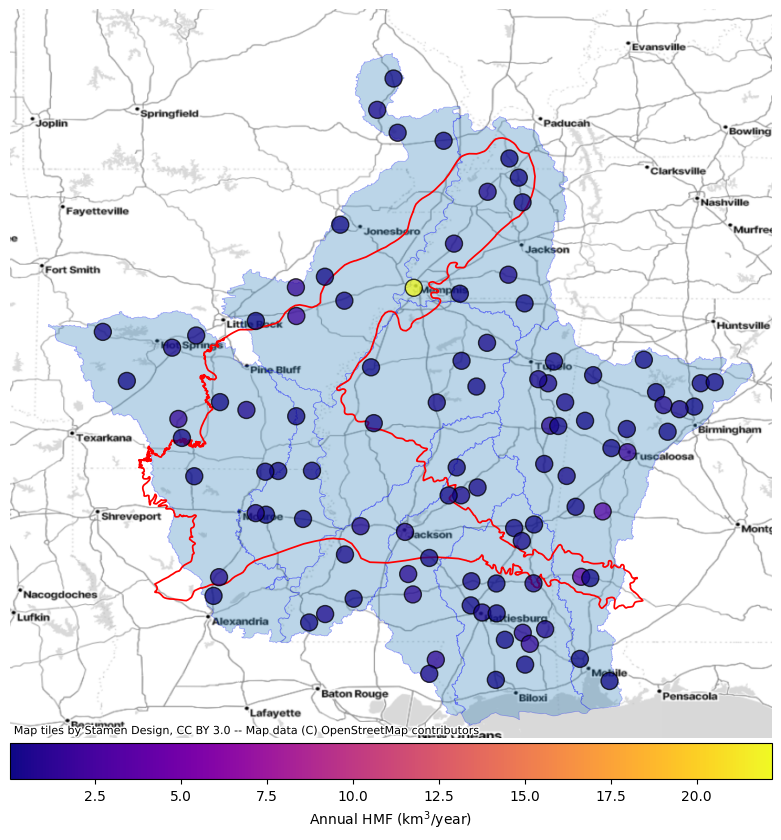

In [49]:
# REQUIRES: df_aq_sites either from Data Creation or multi_site.csv
fig, ax = plt.subplots(figsize=(10, 10))

if os.path.exists('aquifer_sites.csv'):
    df_aq_sites = pd.read_csv('aquifer_sites.csv')

# HUC4 Region Plot
for root, dirs, files in os.walk(directory):
    #print(root, dirs, files)
    if os.path.basename(root).startswith('NHD_H_'):
        if shapefile in files:
            shapefile_aq_path = os.path.join(root, shapefile)
            ws_gdf = gpd.read_file(shapefile_aq_path)
            ws_gdf = ws_gdf.to_crs(4269)
            ws_gdf.plot(ax=ax, edgecolor='blue', alpha=0.30, linewidth=0.5)

# Aquifer boundary plot
aq_shapefile = 'ShapeFiles/Aquifers/Upper_Clairborne_MS/sir2008-5098_UCAQ_extent.shp'
aq_gdf = gpd.read_file(aq_shapefile)
aq_gdf = aq_gdf.to_crs(4269)

xmin, ymin, xmax, ymax = aq_gdf.total_bounds
padding = 1.5
xmin -= padding
ymin -= padding
xmax += padding
ymax += padding

aq_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1.25)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Datapoints plot
lat = df_aq_sites['dec_lat_va'].tolist()
long = df_aq_sites['dec_long_va'].tolist()
geometry = [Point(xy) for xy in zip(long, lat)]
geo_df = gpd.GeoDataFrame(geometry=geometry)

# Set colorbar limits and theme
vmin = df_aq_sites['hmf_per_year'].min()
vmax = df_aq_sites['hmf_per_year'].max()
norm = mcolors.Normalize(vmin, vmax)
cmap = 'plasma'
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(df_aq_sites['hmf_per_year'])

div = make_axes_locatable(ax)
cax = div.append_axes("bottom", size="5%", pad=0.05)

bx = geo_df.plot(ax=ax, column=df_aq_sites['hmf_per_year'], markersize=600, marker='.', cmap=cmap, edgecolor='black', linewidth=1, alpha=0.75)
cbx = plt.colorbar(mappable, cax=cax, pad=0.05, aspect=25, orientation='horizontal', alpha=1.0)
cbx.set_label('Annual HMF ($\mathregular{km^3}$/year)')

ax.margins(0, tight=True)
ax.set_axis_off()
cx.add_basemap(ax, crs=aq_gdf.crs, source=cx.providers.Stamen.TonerLite, zoom=7)

## EXTRA: Single Region Map Creation<br>
This plots sites from 'df_multi_site' within a given region defined by a shapefile, but is not used in the overall Aquifer Analysis<br><br>
Controls:

In [ ]:
shapefile_path = f'ShapeFiles/OR/Whole_State/Shape/WBDHU4.shp'
shape = gpd.read_file(shapefile_path)
size_limit = 999

Region Plot Generation:

In [ ]:
def multi_site_map(df_multi_site: pd.DataFrame, shapefile_path=None):    
    #df = nwis.get_record(sites=SITE_NO, service='site')
    #df2 = nwis.get_record(sites='11303500', service='site')
    lat = df_multi_site['dec_lat_va'].tolist()
    long = df_multi_site['dec_long_va'].tolist()

    fig, ax = plt.subplots(figsize=(9, 9))
    ax.margins(0)

    # This plots the WB shapefile region if one is passed
    shape = gpd.read_file(shapefile_path)
    #print(shape.crs)
    shape.plot(ax=ax, alpha=0.50, edgecolor='black', linewidth=0.5)

    geometry = [Point(xy) for xy in zip(long, lat)]
    geo_df = gpd.GeoDataFrame(geometry=geometry)

    # Set colorbar limits and theme
    vmin = df_multi_site['hmf_per_year'].min()
    vmax = df_multi_site['hmf_per_year'].max()
    norm = mcolors.Normalize(vmin, vmax)
    cmap = 'plasma'
    mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array(df_multi_site['hmf_per_year'])

    # This plots the datapoints
    bx = geo_df.plot(ax=ax, column=df_multi_site['hmf_per_year'], markersize=600, marker='.', cmap=cmap, edgecolor='black', linewidth=1, alpha=0.75)
    cbx = plt.colorbar(mappable, ax=bx, pad=0.01, aspect=25, orientation='horizontal', alpha=1.0)
    cbx.set_label('Annual HMF ($\mathregular{km^3}$/year)')

    #bx.set_title("WBDHU8")
    bx.margins(0, tight=True)
    bx.set_axis_off()

    # This plots the context backmap
    cx.add_basemap(bx, crs=shape.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=8)
    
df_state_sites = filter_state_site(shapefile_path)
df_multi_site = create_multi_site_data(df_state_sites, size_limit)
print(f'Max HMF for this region: {df_multi_site["hmf_per_year"].max():.1f}')
multi_site_map(df_multi_site, shape)

## EXTRA: Mann-Kendall Plot
This plots Mann-Kendall trend lines taken from a completed aquifer spreadsheet but is not used in the overall Aquifer Analysis<br><br>
Controls:

In [ ]:
path = 'aquifer_sites.csv'

Mann-Kendall Plotting:

In [ ]:
# REQUIRES: 'df_multi_site' from 'Gages-II Filter' OR a spreadsheet for testing
df = pd.read_csv(path)
def create_mk_plot(df: pd.DataFrame):
    """Create a plot showing Mann-Kendall trends by site"""
    # Filter only sites that show a trend
    df.reset_index(drop=True, inplace=True)
    df = df[df['mk_h'] == True]

    fig, ax = plt.subplots()

    vmin = df['hmf_per_year'].min()
    vmax = df['hmf_per_year'].max()
    norm = mcolors.Normalize(vmin, vmax)
    cmap = 'viridis'
    mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array(df['hmf_per_year'])

    for _, row in df.iterrows():
        slope = row['mk_slope']
        intercept = row['mk_int']
        val = row['hmf_per_year']
        
        x = np.linspace(0, 25)
        y = slope * x + intercept
        ax.plot(x, y, label=row['site_no'], color=mappable.to_rgba(val))
        
    ax.set_title('Mann-Kendall Trends by Site')
    ax.legend(title='Site No.')
    #ax.axes.get_yaxis().set_ticks([])
    plt.colorbar(mappable, label='Annual HMF ($\mathregular{km^3}$/year)', ax=ax, pad=0.01, aspect=25, orientation='vertical', alpha=1.0)
    #ax.axhline(0, color='black', linewidth=1)
    #ax.axvline(0, color='black', linewidth=1)
    plt.show()

create_mk_plot(df)


## EXTRA: Data Visualization
This was early experimentation with plotting and is completely unused in Aquifer Analysis

Rows: 47
Correlation: 0.6181660900296607


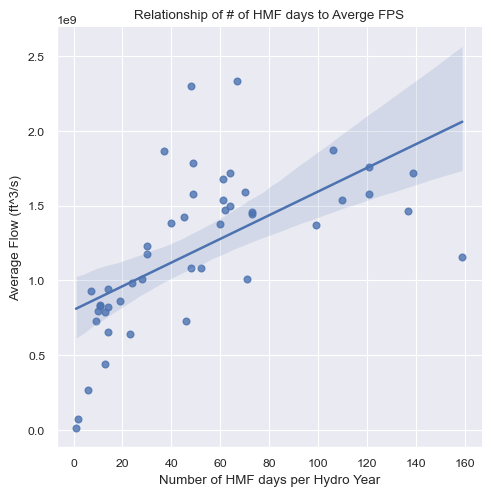

Rows: 39
Correlation w/No Outliers: 0.7340109778858692


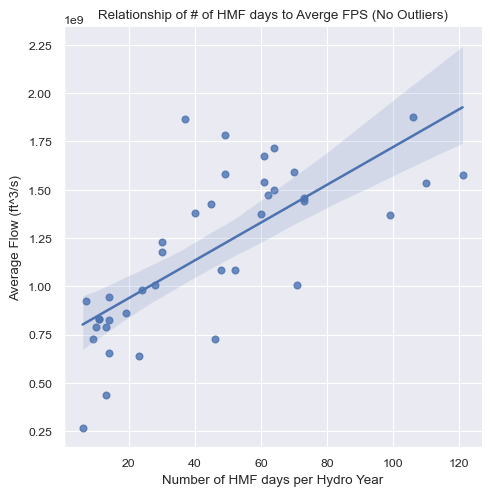

In [7]:
# Scatter plot looking at correlation between # of HMF days per hydrologic year, and average daily flow 
df = nwis.get_record(sites=curr_guage.id, service=SERVICE, parameterCD=PARAM_CODE, start=curr_guage.mean_start_date, end=curr_guage.mean_end_date)
threshold = calc_threshold(df, QUANTILE)
hmf_series = filter_hmf(df, threshold)
hmf_series = convert_hmf(hmf_series, threshold)
#hmf_series.to_csv('hmf_series.csv')
hmf_series = pd.DataFrame(hmf_series)
#hmf_series.set_index('datetime', inplace=True)

# Aggregate dataframe by total flow per day per hydro year, and # of HMF days per hydro year
df_results = hmf_series.resample(HYDRO_YEAR).agg({'00060_Mean': ['sum', 'count']})
df_results.columns = ['Sum', 'Count']
#print(df_results)

# Remove all hydrologic years with no HMF and calculate average FPS/per day
df_results = df_results[df_results['Count'] != 0]
df_results['Average FPS'] = df_results['Sum'] / df_results['Count']
print(f'Rows: {len(df_results)}')

# Correlation
corr = df_results['Count'].corr(df_results['Average FPS'])
print(f'Correlation: {corr}')

# Data Plotting

#plt.figure(figsize=(6, 6))
sns.set(color_codes=True)
sns.set_context('paper')

sns.lmplot(data=df_results, x='Count', y='Average FPS')
plt.xlabel('Number of HMF days per Hydro Year')
plt.ylabel('Average Flow (ft^3/s)')
plt.title('Relationship of # of HMF days to Averge FPS')
plt.show()

# Remove outliers w/Z-score
z_scores = np.abs((df_results - df_results.mean()) / df_results.std())
#print(z_scores)

# Somewhat arbitrary threshold that removes just the most egregious outliers
threshold = 2
df_results_no = df_results[(z_scores <= threshold).all(axis=1)]

print(f'Rows: {len(df_results_no)}')
# Correlation no outliers
corr_no = df_results_no['Count'].corr(df_results_no['Average FPS'])
print(f'Correlation w/No Outliers: {corr_no}')

#plt.figure(figsize=(6, 6))
sns.lmplot(data=df_results_no, x='Count', y='Average FPS')
plt.xlabel('Number of HMF days per Hydro Year')
plt.ylabel('Average Flow (ft^3/s)')
plt.title('Relationship of # of HMF days to Averge FPS (No Outliers)')
plt.show()